# 自动化新素材评分 - 事前模型
* 目的：自动化新素材的评分流程；
* 思路：考虑计划指定的 策略+定向 的影响，选择相关素材下的计划上线情况对素材进行打分；

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
from impala.dbapi import connect
from impala.util import as_pandas
import json
import pymysql
import datetime
from tqdm.auto import tqdm
tqdm.pandas(desc="Processing!")

from script.weight import weights_calcul, weights_assign  # 线性最小二乘的权值编、解码脚本

## 数据模式一：素材评分历史
* select * from dws.dws_image_score_d
* 1条评分记录对应1个素材，1个素材对应1款游戏下的多个包体(game_id)，1个素材评分是1款游戏下该素材投放的所有计划情况；

In [2]:
df_score = pd.read_csv('/home/data/ch_data/dws_image_score_d.csv', encoding='GB2312')

* 删除hr字段

In [3]:
df_score = df_score.drop(['hr'],axis=1)

* 过滤：label_id无效标签

In [4]:
df_score = df_score[df_score['label_ids'].notnull() & (df_score['label_ids'] != '-1') & (df_score['label_ids'] != '\"-1')]

In [5]:
df_score['label_ids'] = df_score['label_ids'].str.replace('-1;', '')
df_score['label_ids'] = df_score['label_ids'].str.replace('-1,', '')
df_score['label_ids'] = df_score['label_ids'].str.replace('\"', '') 
df_score['label_ids'] = df_score['label_ids'].str.replace(';', ',')

In [6]:
# df_score = df_score[df_score['media_id'] == 10]

* 过滤：重复行

In [7]:
df_score = df_score[['image_id', 'image_name', 'label_ids', 'model_run_datetime', 'image_launch_time', 'dt', 'score']]
df_score.drop_duplicates(inplace=True)  # 注意keep=first

In [8]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70846 entries, 4346 to 190957
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   image_id            70846 non-null  int64 
 1   image_name          70846 non-null  object
 2   label_ids           70846 non-null  object
 3   model_run_datetime  70846 non-null  object
 4   image_launch_time   70846 non-null  object
 5   dt                  70846 non-null  object
 6   score               70846 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 4.3+ MB


In [9]:
df_score.head()

,image_id,image_name,label_ids,model_run_datetime,image_launch_time,dt,score
4346,23237,SSR1399-横版（混剪）,19,2020-12-18,2020-07-11,2020-12-18,478
4347,23509,SSR1414-竖版（3D混剪）,20,2020-12-18,2020-07-16,2020-12-18,571
4348,23509,SSR1414-竖版（3D混剪）,20,2020-12-18,2020-07-16,2020-12-18,500
4349,23552,SSR1419-横版（3D混剪）,20,2020-12-18,2020-07-14,2020-12-18,511
4350,23846,SSR1484-横版（3D混剪）,20,2020-12-18,2020-07-27,2020-12-18,540


## 数据模式二：计划信息+素材信息
* 1条评分记录对应1个素材，1个素材对应1款游戏下的多个包体(game_id)，1个素材评分是1款游戏下该素材投放的所有计划情况；

* 采集：计划信息

In [10]:
def get_game_id():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL 
    '''
    cur.execute(sql)
    result_df = cur.fetchall()
    cur.close()
    conn.close()
    return result_df

In [11]:
plan_info = pd.read_csv('/home/data/ch_data/ptom_third_plan.csv')

In [12]:
def get_plan_info():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)
    conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_ptom')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
    /*手动查询*/
        SELECT
                * 
            FROM
                db_ptom.ptom_third_plan p
            WHERE
                game_id IN ({})
                AND media_id = 10
                AND create_time>='2019-01-01'
                AND create_time<= date(NOW())
                            AND plan_id >= (
                                select plan_id from db_ptom.ptom_plan
                                where create_time >= '2019-01-01'
                                and create_time <= '2021-06-01'
                                limit 1
                            )
    '''
    finalSql = sql.format(game_id)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result_df

In [13]:
plan_info_new = get_plan_info()

* 采集：素材信息

In [14]:
image_info = pd.read_csv('/home/data/ch_data/image_info.csv')

In [15]:
def get_image_info():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id,
            a.image_id,
            b.label_ids
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN
            db_data_ptom.ptom_image_info b
        on a.image_id = b.image_id
        WHERE
            a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
            AND a.media_id = 10 
            AND a.create_time >= '2019-01-01' 
        GROUP BY
            a.chl_user_id,
            a.source_id,
            a.image_id
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [16]:
image_info_new = get_image_info()

* 合并

In [17]:
def get_plan_json(plan_info):
    plan_info.drop(['inventory_type', 'budget'], axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info.dropna(subset=['ad_info'], inplace=True)
    # 解析json
    plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
    temp = plan_info['ad_info'].apply(pd.Series)
    plan_info = pd.concat([plan_info, temp], axis=1)
    plan_info.drop('ad_info', axis=1, inplace=True)
    temp = plan_info['audience'].apply(pd.Series)
    plan_info = pd.concat([plan_info, temp], axis=1)
    plan_info.drop('audience', axis=1, inplace=True)
    temp = plan_info['action'].apply(pd.Series)
    plan_info = pd.concat([plan_info, temp], axis=1)
    plan_info.drop('action', axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info = plan_info[['ad_account_id', 'game_id', 'channel_id', 'source_id',
                           'create_time', 'smart_bid_type', 'hide_if_exists', 'budget',
                           'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted',
                           'flow_control_mode', 'schedule_time', 'cpa_bid', 'auto_extend_enabled',
                           'gender', 'city', 'platform', 'launch_price',
                           'retargeting_tags_exclude', 'interest_categories',
                           'ac', 'android_osv', 'location_type', 'retargeting_tags_include',
                           'retargeting_type', 'ios_osv', 'interest_action_mode', 'age',
                           'action_categories', 'action_days', 'action_scene', 'deep_bid_type']]
    return plan_info

In [18]:
# 计划
plan_info = plan_info.append(plan_info_new)
plan_info = get_plan_json(plan_info)
# 素材
image_info = image_info.append(image_info_new)
image_info.dropna(subset=['image_id'], inplace=True)
image_info['image_id'] = image_info['image_id'].astype(int)

In [19]:
df_create = pd.merge(plan_info, image_info, on=['channel_id', 'source_id'], how='left')

In [20]:
# col = ['game_id', 'image_id', 'label_ids', 'create_time', 'smart_bid_type', 'hide_if_exists', 'budget', 'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted', 'flow_control_mode', 'cpa_bid', 'auto_extend_enabled', 'gender', 'city', 'platform', 'launch_price', 'retargeting_tags_exclude', 'interest_categories', 'ac', 'android_osv', 'location_type', 'retargeting_tags_include', 'retargeting_type', 'ios_osv', 'interest_action_mode', 'age', 'action_categories', 'action_days', 'action_scene', 'deep_bid_type']
col = ['game_id', 'image_id', 'label_ids','create_time']  # 'create_time'
df_create = df_create[col]

* 特殊字段

In [21]:
df_create = df_create.mask(df_create.applymap(str).eq('[]'))  # 空list替换为NaN

In [22]:
df_create = df_create.mask(df_create.applymap(str).eq('NONE'))  # NONE替换为NaN

* 过滤

In [23]:
from matplotlib import pyplot as plt

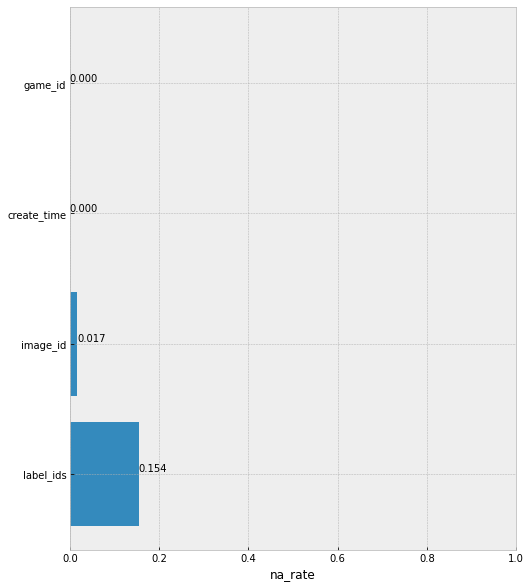

In [24]:
# 各字段缺失率统计
na_rate = (len(df_create) - df_create.count()) / len(df_create)  # 缺失率
a = na_rate.sort_values(ascending=False)  # 倒序
a1 = pd.DataFrame(a)
plt.style.use('bmh')
plt.figure(figsize = (8,10))
plt.barh(range(df_create.shape[1]),a1[0])
plt.xlabel('na_rate')
plt.xlim([0,1])
plt.yticks(range(df_create.shape[1]),a1.index.values.tolist())
for x,y in enumerate(a1[0]):
    plt.text(y,x,'%.3f'%y, va='bottom')

In [25]:
# df_create = df_create.drop(['deep_bid_type', 'action_categories', 'action_scene', 'ios_osv', 'retargeting_tags_include', 'city', 'interest_categories', 'action_days', 'ac', 'retargeting_tags_exclude', 'android_osv', 'retargeting_type'], axis=1)  # 删除缺失率超25%的字段

In [26]:
df_create = df_create[df_create['label_ids'].notnull()]  # 删除'label_ids'字段的NaN行

In [27]:
df_create['image_id'] = df_create['image_id'].astype(int)

In [28]:
df_create.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231214 entries, 4 to 273445
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   game_id      231214 non-null  int64 
 1   image_id     231214 non-null  int64 
 2   label_ids    231214 non-null  object
 3   create_time  231214 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.8+ MB


In [29]:
df_create.head()

,game_id,image_id,label_ids,create_time
4,1000840,19636,19,2020-01-19 16:24:53
5,1000840,19636,19,2020-01-19 16:24:53
8,1000840,19636,19,2020-01-29 18:01:59
9,1000840,19636,19,2020-01-29 18:01:59
12,1000840,19636,19,2020-01-30 14:32:38


## 拼接
* 从素材评分历史出发，每条素材评分的素材ID，关联计划+素材信息的所有game_ids，作为包体集合；

In [30]:
# df_score[df_score['image_id']==19636]  # 5个评分记录

In [31]:
# df_create[df_create['image_id']==19636]  # 7条计划记录

* 拼接素材与包体情况

In [32]:
def merge_my(x, df):
    """ 包体采集："""
     # 对于匹配不到素材id的score记录，其'game_id'为''值
    return ','.join(df[df['image_id']==x['image_id']]['game_id'].value_counts().index.astype(str).tolist())

game_id_series = df_score.progress_apply(lambda x : merge_my(x, df_create), axis=1)

Processing!:   0%|          | 0/70846 [00:00<?, ?it/s]

In [33]:
df = pd.concat([df_score, game_id_series], axis=1)

In [34]:
# df = df.mask(df.applymap(str).eq('NONE'))  # NONE替换为NaN

In [35]:
df.head()

,image_id,image_name,label_ids,model_run_datetime,image_launch_time,dt,score,0
4346,23237,SSR1399-横版（混剪）,19,2020-12-18,2020-07-11,2020-12-18,478,"1000840,1000993,1001258,1001155,1001049"
4347,23509,SSR1414-竖版（3D混剪）,20,2020-12-18,2020-07-16,2020-12-18,571,"1001379,1001400,1000993,1000840,1001049,100125..."
4348,23509,SSR1414-竖版（3D混剪）,20,2020-12-18,2020-07-16,2020-12-18,500,"1001379,1001400,1000993,1000840,1001049,100125..."
4349,23552,SSR1419-横版（3D混剪）,20,2020-12-18,2020-07-14,2020-12-18,511,"1000840,1000993,1001379,1001155,1001049,100125..."
4350,23846,SSR1484-横版（3D混剪）,20,2020-12-18,2020-07-27,2020-12-18,540,"1000993,1001379,1000840,1001155,1001400,1001049"


In [36]:
df.columns = ['image_id','image_name','label_ids','model_run_datetime','image_launch_time','dt','score','game_ids']
df = df[['image_id','image_name','label_ids','model_run_datetime','image_launch_time','game_ids','score']]
df = df[df['game_ids']!='']

In [37]:
df.dropna(axis=0, how='all')
df.reset_index(drop=True, inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51440 entries, 0 to 51439
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   image_id            51440 non-null  int64 
 1   image_name          51440 non-null  object
 2   label_ids           51440 non-null  object
 3   model_run_datetime  51440 non-null  object
 4   image_launch_time   51440 non-null  object
 5   game_ids            51440 non-null  object
 6   score               51440 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.7+ MB
None


,image_id,image_name,label_ids,model_run_datetime,image_launch_time,game_ids,score
0,23237,SSR1399-横版（混剪）,19,2020-12-18,2020-07-11,"1000840,1000993,1001258,1001155,1001049",478
1,23509,SSR1414-竖版（3D混剪）,20,2020-12-18,2020-07-16,"1001379,1001400,1000993,1000840,1001049,100125...",571
2,23509,SSR1414-竖版（3D混剪）,20,2020-12-18,2020-07-16,"1001379,1001400,1000993,1000840,1001049,100125...",500
3,23552,SSR1419-横版（3D混剪）,20,2020-12-18,2020-07-14,"1000840,1000993,1001379,1001155,1001049,100125...",511
4,23846,SSR1484-横版（3D混剪）,20,2020-12-18,2020-07-27,"1000993,1001379,1000840,1001155,1001400,1001049",540


## 特征量化
* 1）label_ids;
* 2）game_ids;
* 3）~~image_name~~：横板、竖版、是否3D等特征;
* 4）~~image_launch_time~~：是否节假日、是否周末等特征;

* score分布情况

/root/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='score', ylabel='Density'>

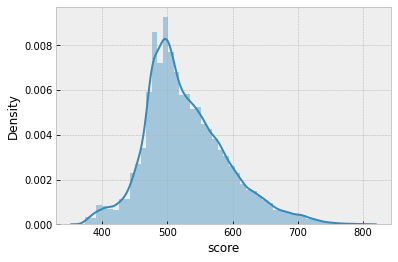

In [38]:
import seaborn as sns
sns.distplot(df['score'])

### label_ids字段处理
* 统计项：单因素加权量化 - 最小二乘

In [39]:
label_ids_mapping = weights_calcul(df, 'label_ids')  # 编码

In [40]:
label_ids_mapping

{'103': 517.0140259792523,
 '111': 324.72526259875707,
 '112': 487.2804878048783,
 '125': 467.4210526315819,
 '126': 507.4460784313728,
 '127': 541.204128848549,
 '13': 479.5000000000011,
 '145': 502.3554817275746,
 '149': 143.76392605556327,
 '158': 506.2857142857109,
 '19': 511.8522771546782,
 '20': 530.2239649298192,
 '21': 479.60869565217536,
 '22': 533.7288267288271,
 '25': 493.0794992513574,
 '26': 461.5833333333337,
 '27': 490.35458107175276,
 '56': 485.04999999999995,
 '67': 513.1116504854368,
 '81': 494.5555555555555,
 '82': 522.8695652173913,
 '83': 357.64297566100737,
 '96': 54.55267938237947,
 '98': 478.03405994550434}

In [41]:
df = weights_assign(df, label_ids_mapping, 'label_ids')  # 解码

100%|██████████| 51440/51440 [00:57<00:00, 894.21it/s]


In [42]:
df['label_ids'] = df['label_ids'].astype(float)

In [43]:
df.head()

,image_id,image_name,label_ids,model_run_datetime,image_launch_time,game_ids,score
0,23237,SSR1399-横版（混剪）,511.852277,2020-12-18,2020-07-11,"1000840,1000993,1001258,1001155,1001049",478
1,23509,SSR1414-竖版（3D混剪）,530.223965,2020-12-18,2020-07-16,"1001379,1001400,1000993,1000840,1001049,100125...",571
2,23509,SSR1414-竖版（3D混剪）,530.223965,2020-12-18,2020-07-16,"1001379,1001400,1000993,1000840,1001049,100125...",500
3,23552,SSR1419-横版（3D混剪）,530.223965,2020-12-18,2020-07-14,"1000840,1000993,1001379,1001155,1001049,100125...",511
4,23846,SSR1484-横版（3D混剪）,530.223965,2020-12-18,2020-07-27,"1000993,1001379,1000840,1001155,1001400,1001049",540


In [44]:
# plt.figure(figsize=(10,5))
# plt.scatter(df['game_ids'],df['score'],marker='^',color='r',label='游戏包体',alpha=0.5)
# plt.axvline(df['game_ids'].mean(),color="b",linewidth=1)
# plt.axhline(df['score'].mean(),color="b",linewidth=1)
# plt.xlabel("game_ids")
# plt.ylabel("score")
# plt.title("line relation")
# plt.grid()
# plt.show()

### game_ids字段处理
* 统计项：单因素加权量化 - 最小二乘

In [45]:
game_ids_mapping = weights_calcul(df, 'game_ids')  # 编码

In [46]:
game_ids_mapping

{'1000840': 7.4808314869756085,
 '1000954': 25.710414903751968,
 '1000960': -95.31973412250603,
 '1000985': 2.505175739556548,
 '1000992': -12.626074758874044,
 '1000993': 89.25606608383225,
 '1000994': -29.529367222362268,
 '1001049': 26.658985706143195,
 '1001155': -21.586235299737083,
 '1001193': 0.8130225663807797,
 '1001194': 30.2719394232387,
 '1001257': 8.670260437520279,
 '1001258': 35.96595128229222,
 '1001259': -50.67147116300396,
 '1001294': 5.694955043385077,
 '1001295': -16.907629817671758,
 '1001379': 466.94282674408964,
 '1001400': 21.7670471863215,
 '1001401': -17.62632358873484,
 '1001402': -57.09488769774797,
 '1001413': -32.20413323354359,
 '1001420': 25.52470391918382,
 '1001425': 2.8858858858858714,
 '1001426': 499.8918918918917,
 '1001430': 23.06812793050435,
 '1001439': -23.23311544938588,
 '1001440': -0.7695520175092371,
 '1001441': -10.930747466475628,
 '1001444': -5.172268670364903,
 '1001447': 3.0592387046984943,
 '1001449': -45.8302371344271,
 '1001457': -8.

In [47]:
df = weights_assign(df, game_ids_mapping, 'game_ids')  # 解码

100%|██████████| 51440/51440 [01:02<00:00, 825.87it/s]


In [48]:
df['game_ids'] = df['game_ids'].astype(float)

In [49]:
df.head()

,image_id,image_name,label_ids,model_run_datetime,image_launch_time,game_ids,score
0,23237,SSR1399-横版（混剪）,511.852277,2020-12-18,2020-07-11,137.775599,478
1,23509,SSR1414-竖版（3D混剪）,530.223965,2020-12-18,2020-07-16,518.992938,571
2,23509,SSR1414-竖版（3D混剪）,530.223965,2020-12-18,2020-07-16,518.992938,500
3,23552,SSR1419-横版（3D混剪）,530.223965,2020-12-18,2020-07-14,482.367278,511
4,23846,SSR1484-横版（3D混剪）,530.223965,2020-12-18,2020-07-27,590.519522,540


### label_ids与game_ids联合处理
* 联合统计项：多因素联合加权量化 - 联合最小二乘（联合loss）

In [50]:
# todo: 

## 建模

In [51]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import plot_importance
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname="/home/simhei.ttf",size=14)
sns.set(font=myfont.get_name())

/root/anaconda3/lib/python3.7/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/root/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/root/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### 训练

In [52]:
x_train, x_test, y_train, y_test = train_test_split(df[['label_ids', 'game_ids']], df[['score']], test_size = 0.3, random_state = 2021, shuffle=True)

In [53]:
xgb_reg_model = XGBRegressor()
xgb_reg_model.fit(x_train, y_train)
pred_train = xgb_reg_model.predict(x_train)
pred_test = xgb_reg_model.predict(x_test)

In [54]:
pred_train = np.expand_dims(pred_train, axis=-1)
pred_test = np.expand_dims(pred_test, axis=-1)

In [55]:
print("训练集MAE: ", mean_absolute_error(pred_train, y_train))
print("测试集MAE: ", mean_absolute_error(pred_test, y_test))

训练集MAE:  44.17093812187787
测试集MAE:  44.21206370383857


No handles with labels found to put in legend.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


========================拟合线============================


/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26465 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 25454 missing fr

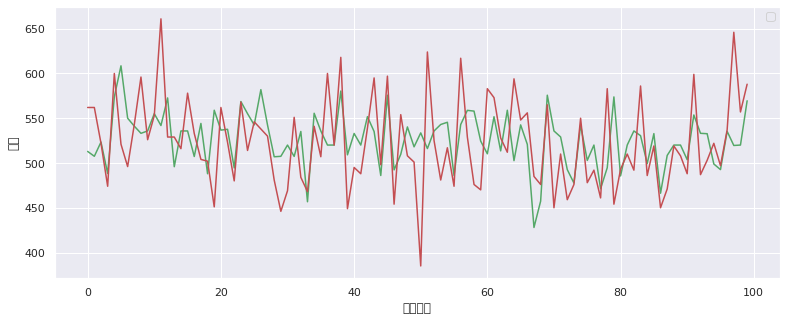

In [56]:
print('========================拟合线============================')
num = 100
plt.figure(figsize=(13,5))
plt.plot(range(num),pred_test[0:num], c='g',)  # 预测值
plt.plot(range(num),y_test[0:num], c='r',)  # 真实值

plt.xlabel('数据条数')
plt.ylabel('分数')
plt.legend()
plt.show()

### 分布比较

/root/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/root/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

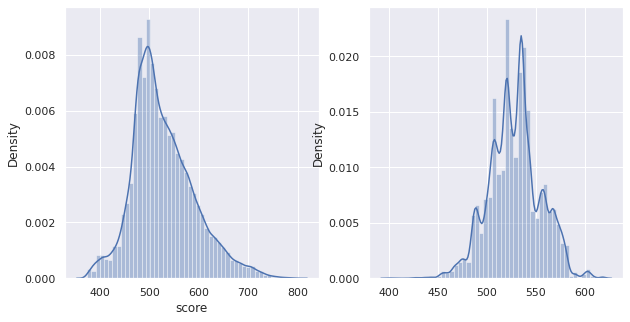

In [57]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))

sns.distplot(df['score'], ax=ax[0])  # 真实值
sns.distplot(xgb_reg_model.predict(df[['label_ids', 'game_ids']]), ax=ax[1])  # 预测值

### 随机验证
* 取df.head()的前N条记录，验证模型输出与实际值的偏差情况

In [58]:
df.head()

,image_id,image_name,label_ids,model_run_datetime,image_launch_time,game_ids,score
0,23237,SSR1399-横版（混剪）,511.852277,2020-12-18,2020-07-11,137.775599,478
1,23509,SSR1414-竖版（3D混剪）,530.223965,2020-12-18,2020-07-16,518.992938,571
2,23509,SSR1414-竖版（3D混剪）,530.223965,2020-12-18,2020-07-16,518.992938,500
3,23552,SSR1419-横版（3D混剪）,530.223965,2020-12-18,2020-07-14,482.367278,511
4,23846,SSR1484-横版（3D混剪）,530.223965,2020-12-18,2020-07-27,590.519522,540


In [59]:
for i in range(100):
    x = np.expand_dims(np.array([df.iloc[i]['label_ids'], df.iloc[i]['game_ids']]), axis=0)
    print("索引{}评分：预测值{:.2f}，真实值{}，偏差{}".format(i, xgb_reg_model.predict(x)[0], df.iloc[i]['score'], xgb_reg_model.predict(x) - df.iloc[i]['score']))

ValueError: feature_names mismatch: ['label_ids', 'game_ids'] ['f0', 'f1']
expected game_ids, label_ids in input data
training data did not have the following fields: f0, f1

### 模型保存

In [60]:
import joblib

In [62]:
joblib.dump(xgb_reg_model, './aimodel/xgb_score_pre.pt')

['./aimodel/xgb_score_pre.pt']

In [ ]:
# df[['image_id', 'label_ids', 'game_ids', 'score']].iloc[:100]

In [ ]:
# ============================================